In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/datasets/ayushuttarwar/makemore-names/names.txt


Trying to implement the algorithm discussed in the research paper, **A Neural Probabilistic Language Model**. 

In the paper they have performed next word prediction but we are going to stick with character level prediction for now.

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('/kaggle/input/datasets/ayushuttarwar/makemore-names/names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
len(words) # words count

32033

In [5]:
# vocabulary building and mapping
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0

itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [6]:
# dataset creation
block_size = 3 # context length

X, Y = [], []
for w in words[:5]:
    print('\n', w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # update the context

X = torch.tensor(X)
Y = torch.tensor(Y)


 emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .

 olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .

 ava
... ---> a
..a ---> v
.av ---> a
ava ---> .

 isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .

 sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


Generated training data using all the words in vocabulary

In [7]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

It's just for first 5 example records

Now we need a look up matrix as described in the research paper. There authors have used 30D matrix because they had around 70k possible words. But we will be using 2D matrix since we have only 27 possible chars

In [8]:
# previously we used OHE to convert the mapping to embeddings
# it'll be used for creating the embedding for each mapping
C = torch.rand((27, 2)) # randomly initialized

In [9]:
C[5] # embedding for 5

tensor([0.2823, 0.3463])

In [10]:
# previous way
F.one_hot(torch.tensor(5), num_classes=27)

tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0])

In [11]:
# now, another way of doing the same thing
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([0.2823, 0.3463])

In [12]:
C[X].shape

torch.Size([32, 3, 2])

In [13]:
X[13, 2] # 13th row and 2nd dim

tensor(1)

In [14]:
# it's representation
C[X][13, 2]

tensor([0.7809, 0.0278])

In [15]:
# same as
C[1]

tensor([0.7809, 0.0278])

In [16]:
embedding = C[X]
embedding.shape

torch.Size([32, 3, 2])

In [17]:
# hidden layer
W1 = torch.randn((6, 100)) # 6 inputs = 3 context * 2 number of each char
b1 = torch.randn(100)

In [18]:
# embedding @ W1 + b1 # won't work, due to incompatible shapes
# embedding[:, 0, :] ---> plucking out the embeddings of first character

# concatenating
torch.cat([embedding[:, 0, :], embedding[:, 1, :], embedding[:, 2, :]], 1).shape

torch.Size([32, 6])

above way isn't perfect because if we change the context size then it'll fail

In [19]:
# solution
torch.cat(torch.unbind(embedding, 1), 1).shape

torch.Size([32, 6])

In [20]:
# another way
h = embedding.view(-1, 6) @ W1 + b1

In [21]:
h.shape

torch.Size([32, 100])

In [22]:
h = torch.tanh(h)

In [23]:
# output layer
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [24]:
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [25]:
# normalization
counts = logits.exp() # taking log
prob = counts/counts.sum(1, keepdims=True)

In [26]:
prob[torch.arange(32), Y]

tensor([1.3500e-01, 1.1057e-09, 5.7266e-10, 4.9805e-01, 1.8917e-01, 1.4554e-09,
        1.1822e-09, 8.6922e-04, 1.2546e-10, 7.2361e-06, 2.8718e-01, 1.4121e-02,
        4.5208e-03, 4.3733e-12, 1.6057e-04, 1.3561e-03, 4.7182e-05, 6.5751e-09,
        1.0422e-04, 4.5490e-13, 1.6569e-05, 2.9882e-10, 1.1542e-09, 7.2051e-01,
        1.1902e-01, 2.1839e-11, 2.1738e-15, 2.7495e-04, 7.2832e-14, 9.2693e-05,
        1.9821e-01, 8.5580e-03])

In [27]:
loss = - prob[torch.arange(32), Y].log().mean()
loss

tensor(13.0015)

### Current Flow

In [28]:
X.shape, Y.shape # dataset

(torch.Size([32, 3]), torch.Size([32]))

In [29]:
g = torch.Generator().manual_seed(2147)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]

In [30]:
# total params
sum(p.nelement() for p in parameters)

3481

In [31]:
for p in parameters:
    p.requires_grad = True

In [32]:
for i in range(50):
    # forward pass
    embedding = C[X] # [32, 3, 2]
    h = torch.tanh(embedding.view(-1, 6) @ W1 + b1) # [32, 100]
    logits = h @ W2 + b2 # [32, 27]
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = - prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Y) # does the same thing
    print(f"loss {i} - {loss.item()}")
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update params
    for p in parameters:
        p.data += -0.1 * p.grad

loss 0 - 19.946653366088867
loss 1 - 16.901782989501953
loss 2 - 14.767463684082031
loss 3 - 12.79350757598877
loss 4 - 11.07797622680664
loss 5 - 9.553297996520996
loss 6 - 8.252641677856445
loss 7 - 7.171950817108154
loss 8 - 6.2747883796691895
loss 9 - 5.556883335113525
loss 10 - 4.990991592407227
loss 11 - 4.485724449157715
loss 12 - 4.016568183898926
loss 13 - 3.587977886199951
loss 14 - 3.208704710006714
loss 15 - 2.8841731548309326
loss 16 - 2.6148922443389893
loss 17 - 2.3880844116210938
loss 18 - 2.188617467880249
loss 19 - 2.008025646209717
loss 20 - 1.8420310020446777
loss 21 - 1.6887471675872803
loss 22 - 1.5476993322372437
loss 23 - 1.419378638267517
loss 24 - 1.3039612770080566
loss 25 - 1.200560450553894
loss 26 - 1.1081061363220215
loss 27 - 1.0257476568222046
loss 28 - 0.9525540471076965
loss 29 - 0.8873438835144043
loss 30 - 0.8289357423782349
loss 31 - 0.7763463854789734
loss 32 - 0.728823184967041
loss 33 - 0.6857370734214783
loss 34 - 0.6464793682098389
loss 35 - 0

Why the loss is so less because the model is getting overfitted because we have provided only 32 samples to the model. Enables model to memories all the combinations (in a way).  

Therefore, **model is overfitting**

In [33]:
logits.max(1)

torch.return_types.max(
values=tensor([ 4.5276,  8.8723, 11.3670, 18.0619, 16.8425,  4.5276,  7.8883, 14.5229,
        13.8298, 13.4347, 12.2948, 16.8088,  4.5276, 13.0339, 17.0011, 17.2538,
         4.5276,  9.1527, 12.9026, 17.0661, 11.8185, 11.6312, 14.5507, 13.0053,
        18.6138,  4.5276,  7.8701, 12.8536, 13.4554, 14.5056, 13.3688, 17.6940],
       grad_fn=<MaxBackward0>),
indices=tensor([19, 13, 13,  1,  0, 19, 12,  9, 22,  9,  1,  0, 19, 22,  1,  0, 19, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0]))

Let's train our neural net on whole dataset

In [34]:
# dataset creation
block_size = 3 # context length

X, Y = [], []
for w in words:
    # print('\n', w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # update the context

X = torch.tensor(X)
Y = torch.tensor(Y)

In [35]:
X.shape, Y.shape # dataset

(torch.Size([228146, 3]), torch.Size([228146]))

### Model Training

In [36]:
# init weights
g = torch.Generator().manual_seed(2147)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]

In [37]:
# total params
sum(p.nelement() for p in parameters)

3481

In [38]:
# enable backpropagation
for p in parameters:
    p.requires_grad = True

In [39]:
for i in range(50):
    # forward pass
    embedding = C[X] # [32, 3, 2]
    h = torch.tanh(embedding.view(-1, 6) @ W1 + b1) # [32, 100]
    logits = h @ W2 + b2 # [32, 27]
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = - prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Y) # does the same thing
    print(f"loss {i} - {loss.item()}")
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update params
    for p in parameters:
        p.data += -0.1 * p.grad

loss 0 - 17.469799041748047
loss 1 - 16.45174217224121
loss 2 - 15.551148414611816
loss 3 - 14.729323387145996
loss 4 - 13.973725318908691
loss 5 - 13.286897659301758
loss 6 - 12.662598609924316
loss 7 - 12.090780258178711
loss 8 - 11.574869155883789
loss 9 - 11.112570762634277
loss 10 - 10.6957426071167
loss 11 - 10.323528289794922
loss 12 - 9.99118423461914
loss 13 - 9.688385009765625
loss 14 - 9.407525062561035
loss 15 - 9.144822120666504
loss 16 - 8.89813232421875
loss 17 - 8.666004180908203
loss 18 - 8.447328567504883
loss 19 - 8.241151809692383
loss 20 - 8.046586036682129
loss 21 - 7.862827777862549
loss 22 - 7.689207077026367
loss 23 - 7.5251851081848145
loss 24 - 7.370285511016846
loss 25 - 7.223982334136963
loss 26 - 7.085634708404541
loss 27 - 6.954460144042969
loss 28 - 6.829632759094238
loss 29 - 6.710399627685547
loss 30 - 6.596146583557129
loss 31 - 6.486410140991211
loss 32 - 6.380837440490723
loss 33 - 6.279157638549805
loss 34 - 6.181154251098633
loss 35 - 6.0866417884

Now we can see the loss is now way larger than previous one. It's due to the increase in dataset size. Also it's taking time to provide loss at each iteration. It's because we are performing forward and backward pass on whole dataset in each iteration. Usually we divide the data into batches and then perform the operations

Like performing the sampling and dividing the datasets into batches and training the model on each batch of dataset

In [40]:
for i in range(50):
    # mini batch
    ix = torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    embedding = C[X[ix]] # [32, 3, 2]
    h = torch.tanh(embedding.view(-1, 6) @ W1 + b1) # [32, 100]
    logits = h @ W2 + b2 # [32, 27]
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = - prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Y[ix]) # does the same thing
    print(f"loss {i} - {loss.item()}")
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update params
    for p in parameters:
        p.data += -0.1 * p.grad

loss 0 - 3.836148738861084
loss 1 - 4.578281879425049
loss 2 - 4.807667255401611
loss 3 - 5.898094177246094
loss 4 - 4.93134880065918
loss 5 - 5.0884294509887695
loss 6 - 5.197519302368164
loss 7 - 4.257833003997803
loss 8 - 4.257508754730225
loss 9 - 4.2267746925354
loss 10 - 4.733624458312988
loss 11 - 5.9347429275512695
loss 12 - 4.785345077514648
loss 13 - 4.504096031188965
loss 14 - 3.767164945602417
loss 15 - 4.248494625091553
loss 16 - 3.8988964557647705
loss 17 - 4.382926940917969
loss 18 - 4.271350860595703
loss 19 - 5.307698726654053
loss 20 - 3.435331106185913
loss 21 - 4.777673244476318
loss 22 - 4.532016754150391
loss 23 - 4.248505115509033
loss 24 - 4.254056930541992
loss 25 - 4.232602119445801
loss 26 - 3.7168993949890137
loss 27 - 4.548818111419678
loss 28 - 5.296840190887451
loss 29 - 5.664127349853516
loss 30 - 5.690046787261963
loss 31 - 4.541640758514404
loss 32 - 3.775475025177002
loss 33 - 3.659959554672241
loss 34 - 3.063183546066284
loss 35 - 3.3347628116607666


Loss also depends upon the learning rate. If the value of learning rate is incorrect then model may get overfit or underfit.

In [41]:
# figuring out the correct value of lr
exp_lr = torch.linspace(-3, 0, 1000)

lrs = 10**exp_lr

In [42]:
lri = []
lossi = []
for i in range(1000):
    # mini batch
    ix = torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    embedding = C[X[ix]] # [32, 3, 2]
    h = torch.tanh(embedding.view(-1, 6) @ W1 + b1) # [32, 100]
    logits = h @ W2 + b2 # [32, 27]
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = - prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Y[ix]) # does the same thing
    # print(f"loss {i} - {loss.item()}")
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update params
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad

    # tracking
    lri.append(exp_lr[i])
    lossi.append(loss.item())

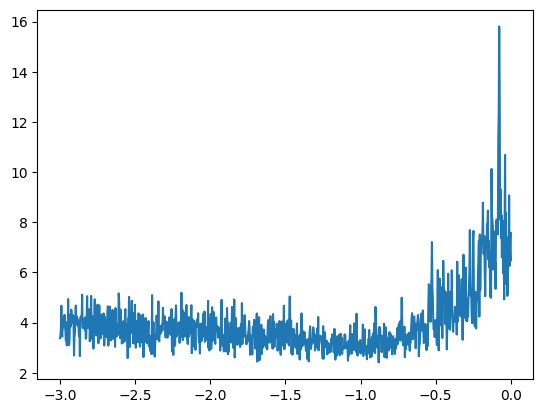

In [43]:
plt.plot(lri, lossi)

turns out that **lr = 1** is the optimal choice for this model

Before training the model we usually splits the data into 3 splits: train, test, validation. So that after training we can examine models performance and will be able to know whether the training is done correctly or not.

In [44]:
def build_dataset(words):
    block_size = 3 # context len
    X, Y = [], []
    for w in words:
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [45]:
import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_tr, Y_tr = build_dataset(words[:n1]) # 80% training data
X_val, Y_val = build_dataset(words[n1:n2]) # 10% validation data
X_te, Y_te = build_dataset(words[n2:]) # 10% testing data

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [46]:
# training to splitted dataset
X_tr.shape, Y_tr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [47]:
# reset the network
# init weights
g = torch.Generator().manual_seed(2147)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]

# total params
total_params = sum(p.nelement() for p in parameters)
print('total parameters: ', total_params)

for p in parameters:
    p.requires_grad = True

total parameters:  3481


In [48]:
for i in range(25000):
    # mini batch
    ix = torch.randint(0, X_tr.shape[0], (32,))
    
    # forward pass
    embedding = C[X_tr[ix]] # [32, 3, 2]
    h = torch.tanh(embedding.view(-1, 6) @ W1 + b1) # [32, 100]
    logits = h @ W2 + b2 # [32, 27]
    loss = F.cross_entropy(logits, Y_tr[ix])
    # print(f"loss {i} - {loss.item()}")
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update params
    for p in parameters:
        p.data += -0.1 * p.grad

In [49]:
# training loss
emb = C[X_tr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_tr)
loss

tensor(2.4550, grad_fn=<NllLossBackward0>)

In [50]:
# evaluate
emb = C[X_val]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_val)
loss # validation loss

tensor(2.4504, grad_fn=<NllLossBackward0>)

As we can see that training loss and validation loss is almost equal. This little difference in their loss values showcase that our model is performing quite well on unseen data also and it's not overfitting to training data.

**Let's try with the bigger network now!**

In [51]:
# reset the network
# init weights
g = torch.Generator().manual_seed(2147)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]

# total params
total_params = sum(p.nelement() for p in parameters)
print('total parameters: ', total_params)

for p in parameters:
    p.requires_grad = True

total parameters:  10281


In [52]:
lossi = []
stepi = []

for i in range(35000):
    # mini batch
    ix = torch.randint(0, X_tr.shape[0], (32,))
    
    # forward pass
    embedding = C[X_tr[ix]] # [32, 3, 2]
    h = torch.tanh(embedding.view(-1, 6) @ W1 + b1) # [32, 100]
    logits = h @ W2 + b2 # [32, 27]
    loss = F.cross_entropy(logits, Y_tr[ix])
    # print(f"loss {i} - {loss.item()}")
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update params
    for p in parameters:
        p.data += -0.1 * p.grad

    # tracking
    stepi.append(i)
    lossi.append(loss.item())

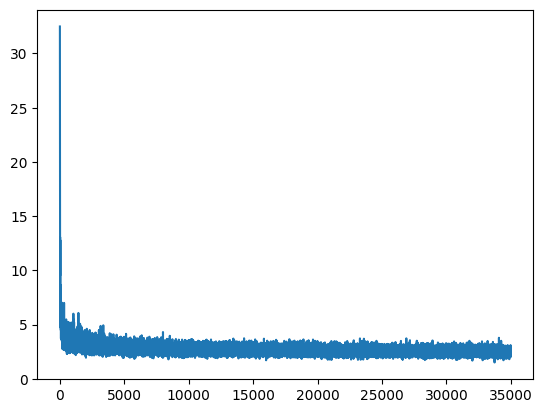

In [53]:
plt.plot(stepi, lossi)

We can see that after few iterations only loss dropped significantly. After that the thickness implies the fluctuations in weights optimizations because we are creating mini batches on training data which creates little bit of noise.

Our model converged at starting then started fluctuating it can be due to small batch size

In [54]:
# evaluate
emb = C[X_val]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_val)
loss # validation loss

tensor(2.4306, grad_fn=<NllLossBackward0>)

Even after increasing the model size the change in loss is very low (almost negligible) it can be due to several factors like:  
- small batch size
- low dimensionality of embeddings

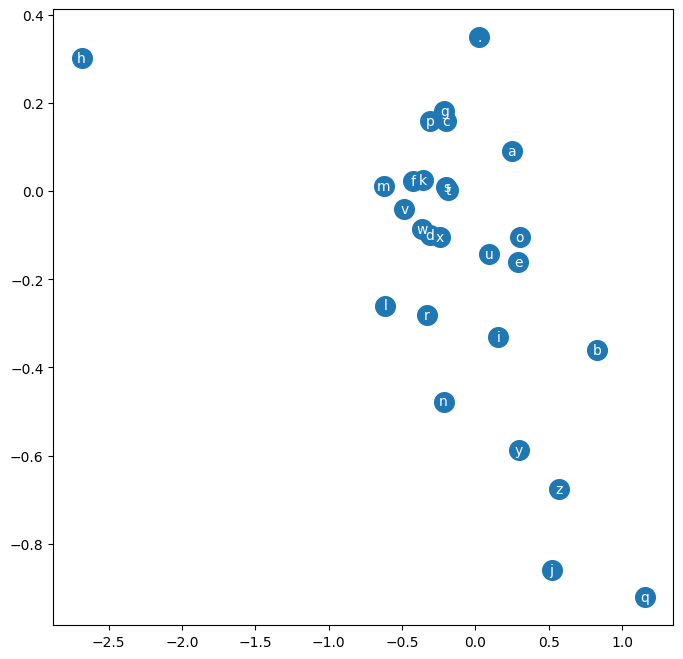

In [55]:
# visualizing the embeddings
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha='center', va='center', color='white')


**Takeaways from above plot:"**
- Chars which are grouped implies that they have very similar embedding structure so it makes model harder to predict the correct one (eg. 't' & 's' have very similar embedding values)
- Chars which are far away are easily predictable (eg. 'q' & 'j')

***BAsed on the plot it seems that embedding's dimensionality is one of the major cause why our model isn't improviing***

In [56]:
# with higher embedding dimensionality

# init weights
g = torch.Generator().manual_seed(2147)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]

# total params
total_params = sum(p.nelement() for p in parameters)
print('total parameters: ', total_params)

for p in parameters:
    p.requires_grad = True

total parameters:  11897


In [57]:
lossi = []
stepi = []

In [58]:
for i in range(35000):
    # mini batch
    ix = torch.randint(0, X_tr.shape[0], (32,))
    
    # forward pass
    embedding = C[X_tr[ix]] # [32, 3, 2]
    h = torch.tanh(embedding.view(-1, 30) @ W1 + b1) # [32, 100]
    logits = h @ W2 + b2 # [32, 27]
    loss = F.cross_entropy(logits, Y_tr[ix])
    # print(f"loss {i} - {loss.item()}")
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update params
    for p in parameters:
        p.data += -0.01 * p.grad

    # tracking
    stepi.append(i)
    lossi.append(loss.log10().item())

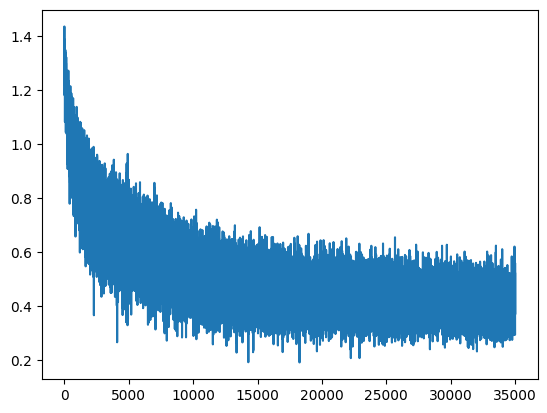

In [59]:
# logloss
plt.plot(stepi, lossi)

In [60]:
# evaluate
emb = C[X_val]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_val)
loss # validation loss

tensor(2.5764, grad_fn=<NllLossBackward0>)

In [61]:
# training loss
emb = C[X_tr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_tr)
loss

tensor(2.5543, grad_fn=<NllLossBackward0>)

In [62]:
# testing loss
emb = C[X_tr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_tr)
loss

tensor(2.5543, grad_fn=<NllLossBackward0>)

We can see gap between training loss and validation loss which implies that our model is starting to overfit now.

In [63]:
# makng the predictions
g = torch.Generator().manual_seed(1337)

# generating 20 words
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

gun.
kateaba.
deven.
dell.
elqlecherdorsyondarrina.
nyn.
vabeavias.
khrugh.
mareaviphoalian.
alaydrea.
keirseai.
laye.
taodah.
halyn.
rayc.
jazia.
arbuav.
avaitamilea.
lajionen.
hea.


***This time the words are much more appealing and some words looks like a real names which shows that we are improving***